In [43]:
import pandas as pd  
import numpy as np 
import joypy
import matplotlib.pyplot as plt
from  matplotlib import cm


# for time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# for regression
import statsmodels.api as sm


plt.style.use('ggplot')

%cd ..

trends_df = pd.read_csv('Datasets/raw/raw_trends_data.csv')

We investigate which cities have a reasonable amount of observations per year and exclude cities that don't meet our criteria. We summarise the count of non missing values for each city and each year and plot the distribution and print a few quantiles

0.05    25.75
0.10    36.00
0.15    39.00
0.20    39.00
0.25    40.00
0.30    41.00
0.50    49.00
Name: Elbil, dtype: float64


(array([  9.,   2.,   2.,   2.,   2.,   2.,   4.,   3.,   0.,   4.,   2.,
          2.,   2.,   4.,   1.,   4.,   2.,   2.,   4.,   3.,   6.,   7.,
          8.,   0.,   3.,   9.,   2.,   6.,   2.,   6.,  15.,  13.,   7.,
         10.,  12.,  20.,  36., 179.,  77.,  17.,  71.,  16.,  69.,  15.,
         61.,  30.,  28., 142.,  84., 589.]),
 array([ 0.  ,  1.04,  2.08,  3.12,  4.16,  5.2 ,  6.24,  7.28,  8.32,
         9.36, 10.4 , 11.44, 12.48, 13.52, 14.56, 15.6 , 16.64, 17.68,
        18.72, 19.76, 20.8 , 21.84, 22.88, 23.92, 24.96, 26.  , 27.04,
        28.08, 29.12, 30.16, 31.2 , 32.24, 33.28, 34.32, 35.36, 36.4 ,
        37.44, 38.48, 39.52, 40.56, 41.6 , 42.64, 43.68, 44.72, 45.76,
        46.8 , 47.84, 48.88, 49.92, 50.96, 52.  ]),
 <a list of 50 Patch objects>)

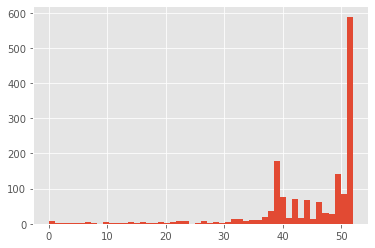

In [27]:
#Summarising by group
few = trends_df.groupby(['City', 'Region', 'year'], dropna = False, as_index = False).count().reset_index()
print(few['Elbil'].quantile([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]))
plt.hist(few['Elbil'], bins = 50)

We see that we can keep 95% of our data by choosing a cutoff for the number of NA allowed to be present in a city over a year to be 26. we also see that 50% of our data is only missing less that 4 observations per year 
We argue that allowing cities to have at max half of their observations be NA is permissable in our context as we will infer their values using a rolling window. The first peak in the histogram we have found is also due to a systematic failure of the API to retrieve data for all cities in a 2-month period in 2021 (equal to eight observations), which would bring it closer to the mode of the distribution (evident by joyplot below).

Since we are working with time series we will impute the missing values by using a centered rolling window over the series. The size of the window we set to be 12 

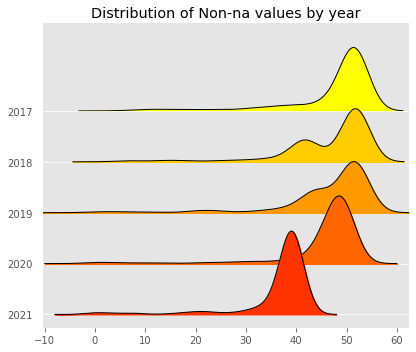

In [28]:
fig, axes = joypy.joyplot(few, by="year", column="Elbil", range_style='own', 
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Distribution of Non-na values by year",
                          colormap=cm.autumn_r)

In [29]:
few = few[few['Elbil'] < 26 ][['City', 'Region', 'year']].drop_duplicates() #create table of observations with many NAs to be used for filtering

group_df = trends_df.groupby(['City', 'Region'])['Elbil'].rolling(window=12, min_periods=1, center=True).mean().reset_index()
group_df = group_df.set_index('level_2')
group_df = group_df.rename(columns = {'Elbil':'Elbil_rolling'})
trends_df = trends_df.join(group_df['Elbil_rolling'])


trends_df['Elbil'] = trends_df.apply(
    lambda row: row['Elbil_rolling'] if np.isnan(row['Elbil']) else row['Elbil'],
    axis=1
)

trends_df['Elbil'] = trends_df.apply(
    lambda row: 0 if np.isnan(row['Elbil']) else row['Elbil'],
    axis=1
)


In [30]:
def trend_function(x):
    # do your lambda function here as you are sending each grouping
      x = x.assign(
      trend = lambda x: x["Elbil"].mask(~x["Elbil"].isna(), other = 
      seasonal_decompose(x["Elbil"][~x["Elbil"].isna()], model='aditive', extrapolate_trend='freq', period = 4).trend))
      return x
trends_df = trends_df.groupby(['City', 'year', 'Region'], as_index = False).apply(trend_function).reset_index()

trends_df['trend'][(trends_df.year.isin(few.year.values.tolist()) & trends_df.City.isin(few.City.values.tolist()) & trends_df.Region.isin(few.Region.values.tolist()) )] = np.nan
trends_df['Elbil'][(trends_df.year.isin(few.year.values.tolist()) & trends_df.City.isin(few.City.values.tolist()) & trends_df.Region.isin(few.Region.values.tolist()) )] = np.nan

trends_df.head(20)


/tmp/ipykernel_16650/2956477146.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trends_df['trend'][(trends_df.year.isin(few.year.values.tolist()) & trends_df.City.isin(few.City.values.tolist()) & trends_df.Region.isin(few.Region.values.tolist()) )] = np.nan
/tmp/ipykernel_16650/2956477146.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trends_df['Elbil'][(trends_df.year.isin(few.year.values.tolist()) & trends_df.City.isin(few.City.values.tolist()) & trends_df.Region.isin(few.Region.values.tolist()) )] = np.nan


,level_0,level_1,Unnamed: 0,City,Region,Sports,Elbil,included,interval,week,year,Elbil_rolling,trend
0,0,247,249,Aabenraa,Syddanmark,94.0,6.0,1.0,2016-12-26T00 2017-01-01T00,1,2017,7.833333,11.225
1,0,566,570,Aabenraa,Syddanmark,93.0,7.0,1.0,2017-01-02T00 2017-01-08T00,2,2017,7.142857,10.250
2,0,885,891,Aabenraa,Syddanmark,89.0,11.0,1.0,2017-01-09T00 2017-01-15T00,3,2017,6.750000,8.750
3,0,1204,1212,Aabenraa,Syddanmark,92.0,8.0,1.0,2017-01-16T00 2017-01-22T00,4,2017,6.555556,9.000
4,0,1523,1533,Aabenraa,Syddanmark,88.0,12.0,1.0,2017-01-23T00 2017-01-29T00,5,2017,6.800000,7.500
5,0,1842,1854,Aabenraa,Syddanmark,97.0,3.0,1.0,2017-01-30T00 2017-02-05T00,6,2017,6.909091,6.000
6,0,2161,2175,Aabenraa,Syddanmark,97.0,3.0,1.0,2017-02-06T00 2017-02-12T00,7,2017,6.583333,4.625
7,0,2480,2496,Aabenraa,Syddanmark,96.0,4.0,1.0,2017-02-13T00 2017-02-19T00,8,2017,6.666667,4.500
8,0,2799,2817,Aabenraa,Syddanmark,95.0,5.0,1.0,2017-02-20T00 2017-02-26T00,9,2017,7.000000,5.875
9,0,3118,3138,Aabenraa,Syddanmark,91.0,9.0,1.0,2017-02-27T00 2017-03-05T00,10,2017,6.916667,6.375


In [31]:
def regress_mean(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    year_mean = pd.Series({'mean' : np.mean(Y)})
    result = sm.OLS(Y, X).fit()
    res = result.params
    res = res.rename({'week' : 'slope'})
    rsquared = pd.Series({'R2' : result.rsquared})
    rsquared_adj = pd.Series({'R2_adj' : result.rsquared_adj})
    res = res.append(to_append=[rsquared, rsquared_adj, year_mean])
    return res

trends_df_regr = trends_df.groupby(['City', 'year', 'Region'], as_index = False).apply(regress_mean, 'trend', ['week']).reset_index()


0.1   -0.005479
0.2    0.043718
0.3    0.121279
0.4    0.223551
0.5    0.339963
0.6    0.444430
Name: R2_adj, dtype: float64


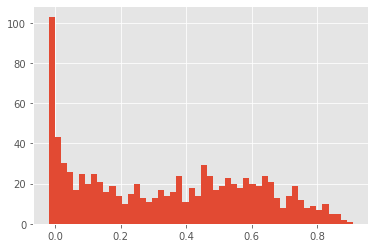

In [32]:
plt.hist(trends_df_regr['R2_adj'], bins= 50)
print(trends_df_regr['R2_adj'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]))

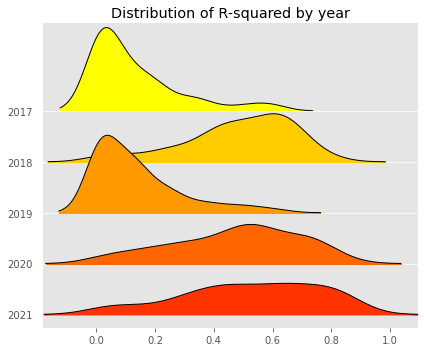

In [33]:
fig, axes = joypy.joyplot(trends_df_regr, by="year", column="R2", range_style='own', 
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Distribution of R-squared by year",
                          colormap=cm.autumn_r)

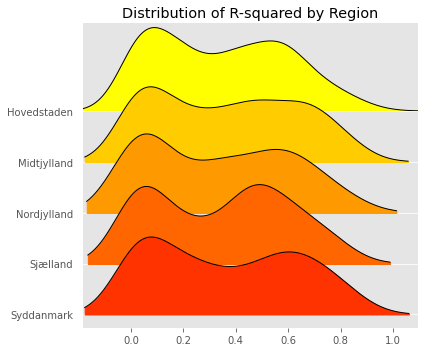

In [34]:
fig, axes = joypy.joyplot(trends_df_regr, by="Region", column="R2", range_style='own', 
                          grid="y", linewidth=1, legend=False, figsize=(6,5),
                          title="Distribution of R-squared by Region",
                          colormap=cm.autumn_r)

From the joyplots we observe that the distribution of R-squared across years differ with 2017 and 2019 displaying mostly R-squared in the range between 0 and 0.2. This equivalent of saying that time passing explains little to no of the variance for most cities in those years, as such the slope values are not meaningful as the data in those years are best described using the mean. However for the years 2018, 2020 and 2021 we do see a more uniform distribution of R-squared with the majority of the density mass being above 0.3. This suggests that in those years time is a predictor of the trend for the majority of cities.

In [35]:
for year in trends_df_regr.year.unique():
    print(f'Quantile of R2 for region {year} ')
    print(trends_df_regr['R2_adj'][(trends_df_regr.year == year)].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]))

Quantile of R2 for region 2017 
0.1   -0.016888
0.2   -0.009105
0.3    0.004121
0.4    0.026134
0.5    0.054089
0.6    0.094120
Name: R2_adj, dtype: float64
Quantile of R2 for region 2018 
0.1    0.211447
0.2    0.356304
0.3    0.396561
0.4    0.459777
0.5    0.503507
0.6    0.558416
Name: R2_adj, dtype: float64
Quantile of R2 for region 2019 
0.1   -0.016601
0.2   -0.007957
0.3    0.006300
0.4    0.038285
0.5    0.086846
0.6    0.112638
Name: R2_adj, dtype: float64
Quantile of R2 for region 2020 
0.1    0.139591
0.2    0.263875
0.3    0.355070
0.4    0.445799
0.5    0.488515
0.6    0.536256
Name: R2_adj, dtype: float64
Quantile of R2 for region 2021 
0.1    0.170808
0.2    0.314248
0.3    0.390717
0.4    0.453257
0.5    0.533744
0.6    0.612866
Name: R2_adj, dtype: float64


We now engineer a final variable to indicate whether the city is exhibiting a trend within a given year according to its value of R-squared. The criterion of R-squared is of course very arbitrarily chosen but we have settled on an R-squared of 0.4. In social science context we believe that is an acceptable R-squared that would still clearly separate the years with little to no trend (2017 and 2019) from the years that systematically exhibit a trend.

In [39]:
trends_df_regr['trending'] = (trends_df_regr['R2'] >= 0.4).apply(int)

As hypothesized there is little to no trend in 2017 and 2019. However we also see that the majority of slopes are positive. This suggests that on average across Denmark we would expect to see a positive trend in 2018, 2020 and 2021. 

Text(0.5, 1.0, 'Average trend across Denmark')

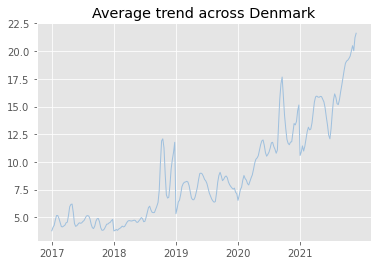

In [24]:
plt_data = trends_df.groupby(['year', 'week'], as_index = False).mean().reset_index()

plt.plot(range(0, len(plt_data['year'])), plt_data['trend'], '-',linewidth=1,label='raw',color='#9FC0DE')
ticks = [0, 52, 104, 156, 208]
labs = [2017, 2018, 2019, 2020, 2021]
plt.xticks(ticks, labs)
plt.title('Average trend across Denmark')

In [40]:
trends_df_regr.to_csv('Datasets/aggregated/preproccesed_trends_data.csv')

In [42]:
len(trends_df_regr.City.unique())

319